In [1]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'2.0.0'

In [3]:
imgs_path = glob.glob(r'D:\163\gan20\pix2pix\datasets\cityscapes_data\train\*.jpg')

In [4]:
len(imgs_path)

2975

In [5]:
imgs_path[:3]

['D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\1.jpg',
 'D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\10.jpg',
 'D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\100.jpg']

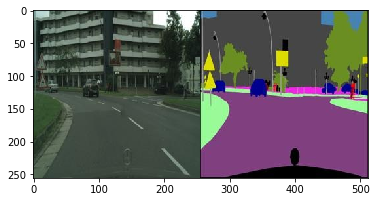

In [6]:
plt.imshow(
    tf.keras.preprocessing.image.load_img(imgs_path[0])
)

In [7]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [8]:
def normalize(musk, image):
    musk = tf.cast(musk, tf.float32)/127.5 - 1
    image = tf.cast(image, tf.float32)/127.5 - 1
    return musk, image

In [9]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w//2
    input_mask = image[:, w:, :]
    input_image = image[:, :w, :]
    
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_mask, input_image = normalize(input_mask, input_image)
    
    return input_mask, input_image

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

In [11]:
dataset = dataset.map(load_image)

In [12]:
dataset

<MapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

In [13]:
BCTCH_SIZE = 16
BUFFER_SIZE = 200

In [14]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)

In [15]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

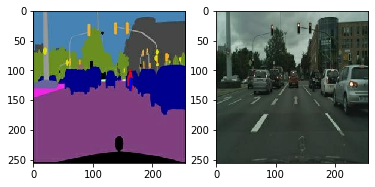

In [16]:
for musk, img in dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [17]:
imgs_test = glob.glob(r'D:\163\gan20\pix2pix\datasets\cityscapes_data\val\*.jpg')

In [18]:
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_test)

In [19]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w//2
    input_mask = image[:, w:, :]
    input_image = image[:, :w, :]
    
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    input_mask, input_image = normalize(input_mask, input_image)
    
    return input_mask, input_image

In [20]:
dataset_test = dataset_test.map(load_image_test)

In [21]:
dataset_test = dataset_test.batch(BCTCH_SIZE)

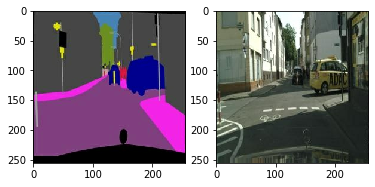

In [22]:
for musk, img in dataset_test.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [30]:
def down(filters, size, apply_bn=True):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False)
    )
    if apply_bn:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

In [37]:
def up(filters, size, apply_drop=False):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                        padding='same', use_bias=False)
    )
    model.add(tf.keras.layers.BatchNormalization())
    if apply_drop:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

In [42]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    down_stack = [
        down(64, 4, apply_bn=False),     #128*128*64
        down(128, 4),                    #64*64*128
        down(256, 4),                    #32*32*256
        down(512, 4),                    #16*16*512
        down(512, 4),                    #8*8*512
        down(512, 4),                    #4*4*512
        down(512, 4),                    #2*2*512
        down(512, 4),                    #1*1*512
    ]
    
    up_stack = [
        up(512, 4, apply_drop=True),      #2*2*512
        up(512, 4, apply_drop=True),      #4*4*512
        up(512, 4, apply_drop=True),      #8*8*512
        up(512, 4),                        #16*16*512
        up(256, 4),                        #32*32*256
        up(128, 4),                        #64*64*128
        up(64, 4),                         #128*128*64
    ]
    
    x = inputs
    
    skips = []     
    
    for d in down_stack:
        x = d(x)
        skips.append(x)
        
    skips = reversed(skips[ :-1])
    
    for u, skip in zip(up_stack, skips):
        x = u(x)
        x = tf.keras.layers.Concatenate()([x, skip])    # x为 128*128*128
        
    x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, 
                                        padding='same', 
                                        activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [43]:
generator = Generator()

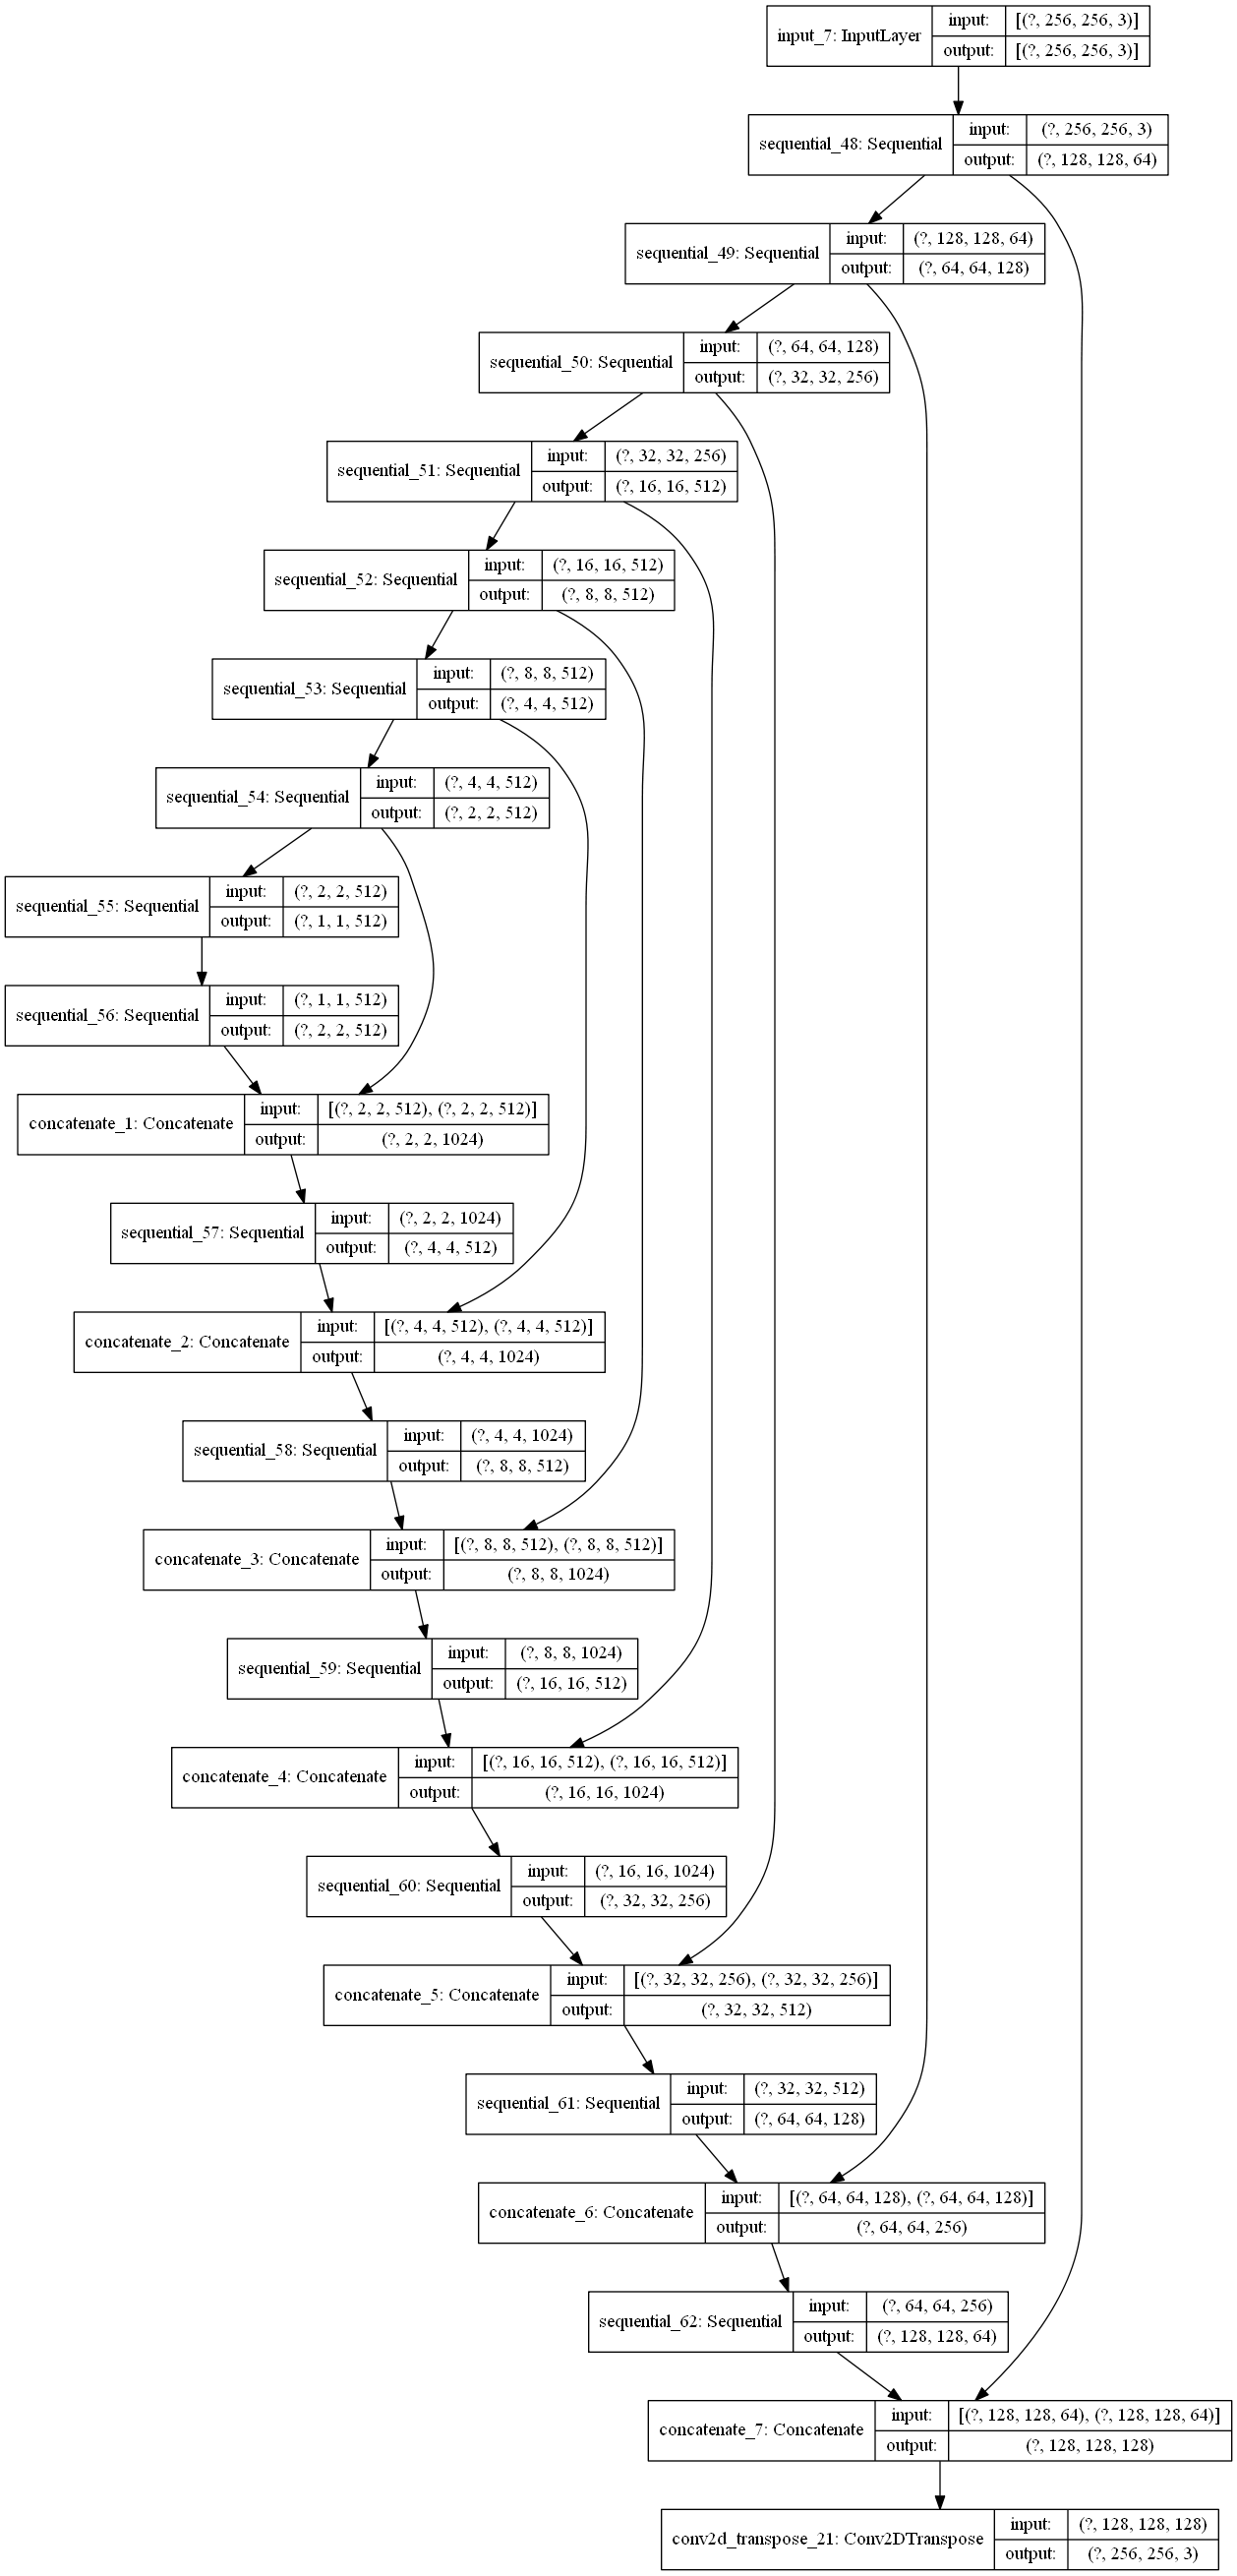

In [44]:
tf.keras.utils.plot_model(generator, show_shapes=True)

1.成对的图像

2. patch D

In [47]:
def Disc():
    inp = tf.keras.layers.Input(shape=(256, 256, 3))
    tar = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.concatenate([inp, tar])   # 256, 256, 6
    
    x = down(64, 4, apply_bn=False)(x)               # 128, 128, 64
    x = down(128, 4)(x)                              # 64, 64, 128
    x = down(256, 4)(x)                              # 32, 32, 256
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1, 
                               padding='same',
                               use_bias=False)(x)    # 32, 32, 512
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, 3, strides=1)(x)   # 30, 30, 1
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [48]:
disc = Disc()

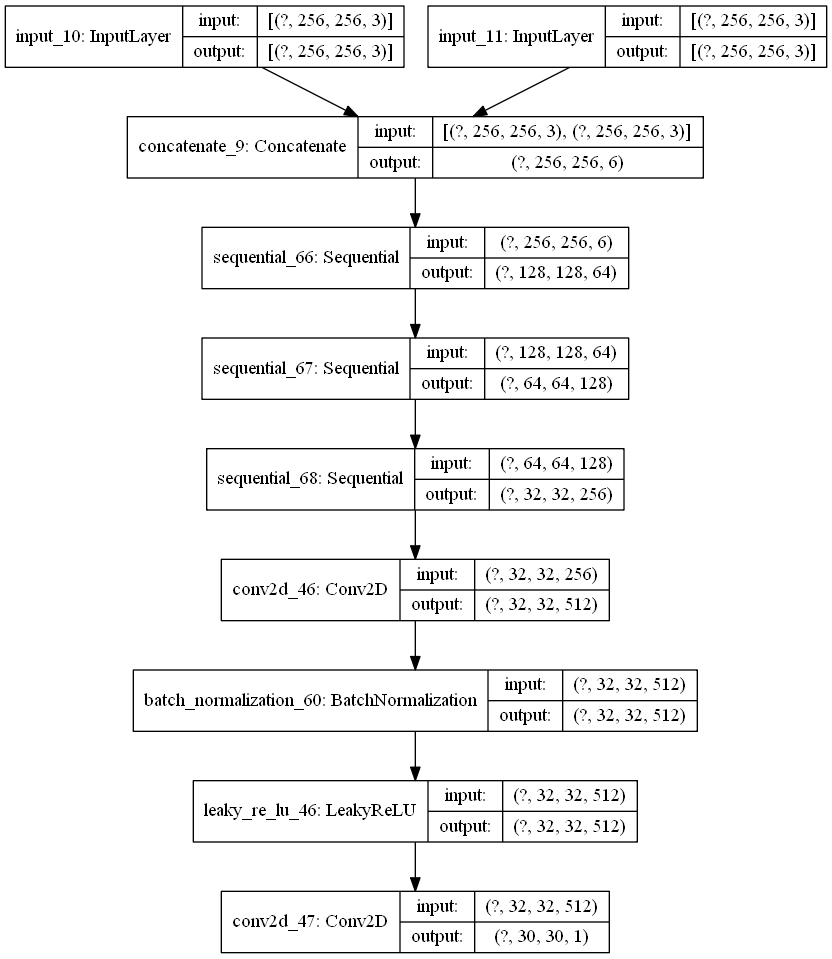

In [49]:
tf.keras.utils.plot_model(disc, show_shapes=True)

In [51]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
LAMBDA = 10

In [53]:
def gen_loss(d_gen_output, gen_output, target):
    gen_loss = loss_fn(tf.ones_like(d_gen_output), d_gen_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    return gen_loss + LAMBDA*l1_loss

In [55]:
def disc_loss(d_real_output, d_gen_output):
    real_loss = loss_fn(tf.ones_like(d_real_output), d_real_output)
    g_loss = loss_fn(tf.zeros_like(d_gen_output), d_gen_output)
    return real_loss + g_loss

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [57]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [58]:
EPOCHS = 150

In [66]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)

        gen_total_loss = gen_loss(disc_generated_output, gen_output, target)
        disc_loss = disc_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [67]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            train_step(input_image, target, epoch)
        print()

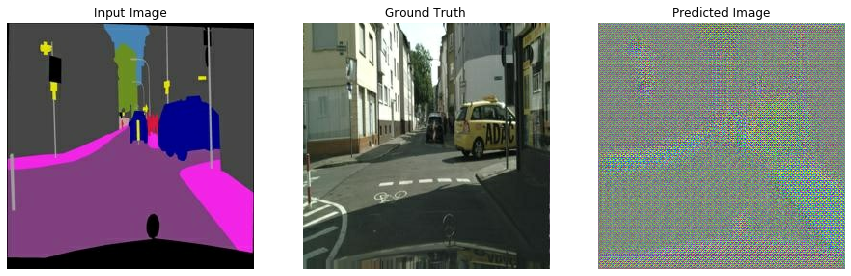

Epoch:  0
.

StagingError: in converted code:

    <ipython-input-66-a0a6a50d9fab>:10 train_step  *
        disc_loss = disc_loss(disc_real_output, disc_generated_output)

    UnboundLocalError: local variable 'disc_loss' referenced before assignment


In [68]:
fit(dataset, EPOCHS, dataset_test)